## Language Detection of Tweets

Dataset Source: https://www.kaggle.com/datasets/lailaboullous/language-detection-dataset

#### Install Missing & Necessary Libraries

In [1]:
%pip install --upgrade pip
%pip install --upgrade datasets transformers evaluate ipykernel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Import Necessary Libraries

In [2]:
import sys, os
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, set_seed
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

import evaluate

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


#### Display Versions of Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.23.3
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1
         Torch: 1.12.1
      Evaluate: 0.4.0


#### Load & Start Processing Dataset

In [4]:
parent_dir = "/Users/briandunn/Desktop/nlp_ds/Language Detection w tweets"

df = pd.read_csv(os.path.join(parent_dir, "language_detection_data_s.csv"))

# Remove leading '\' characters
df["Text"] = df["Text"].str.lstrip(r'\\')

# Remove '\n' no matter where they are located
df.replace({r"\n": ""}, regex=True, inplace=True)

# Drop samples with missing values
df = df.dropna()

# Remove leading & trailing spaces
df["Text"] = df["Text"].str.strip()
df["Language"] = df["Language"].str.strip()

# Change Feature names
df.rename(columns={"Text": "text", "Language": "labels"}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13153 entries, 0 to 13152
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13153 non-null  object
 1   labels  13153 non-null  object
dtypes: object(2)
memory usage: 205.6+ KB


#### Visualize: Length Text Length (in Words)

The maximum length of this dataset is approximately 137 words.


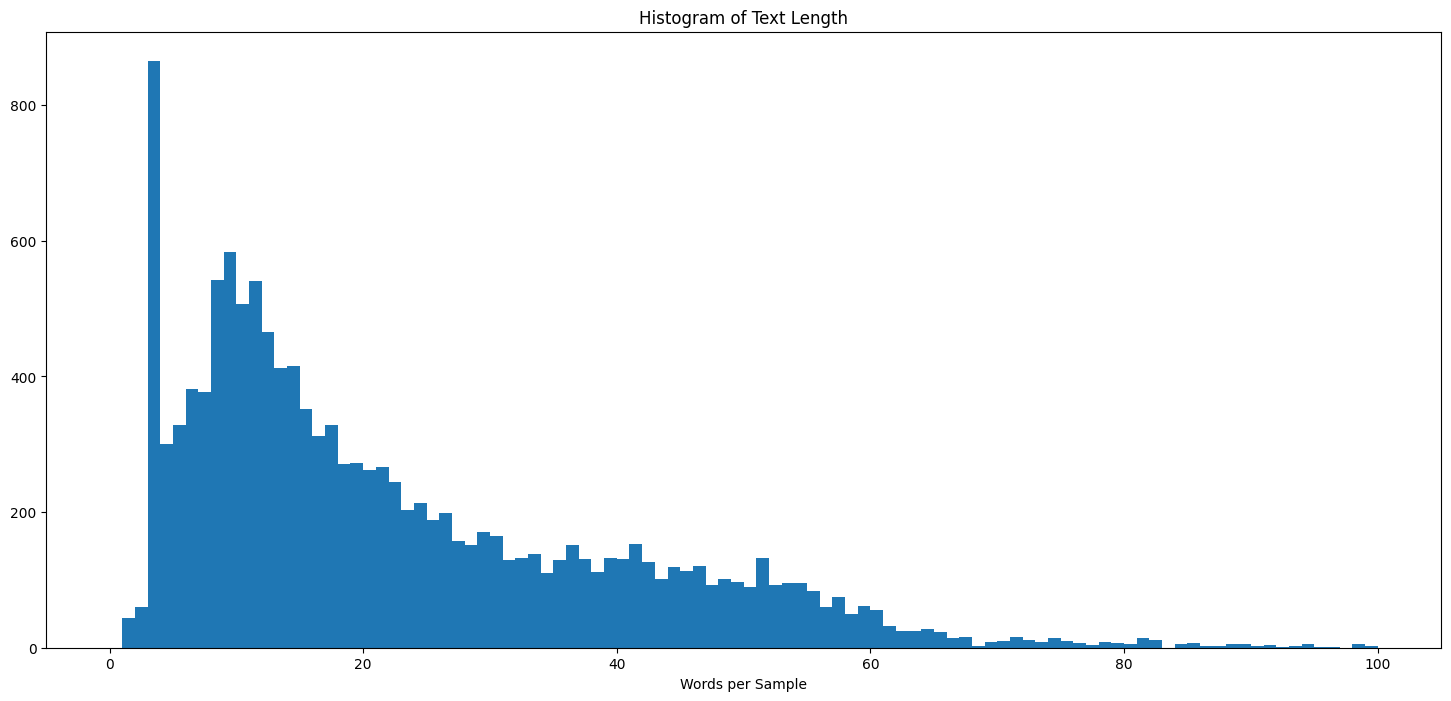

In [5]:
df['Text Length'] = df['text'].str.split().str.len()

max_len = df['Text Length'].max()
print(f"The maximum length of this dataset is approximately {max_len} words.")

n = 100
df.hist('Text Length', grid=False, figsize=(18,8), range=(0, n), bins=n)
plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Sample')
plt.show()

#### Visualize: Length Text Length (in Words) By Language

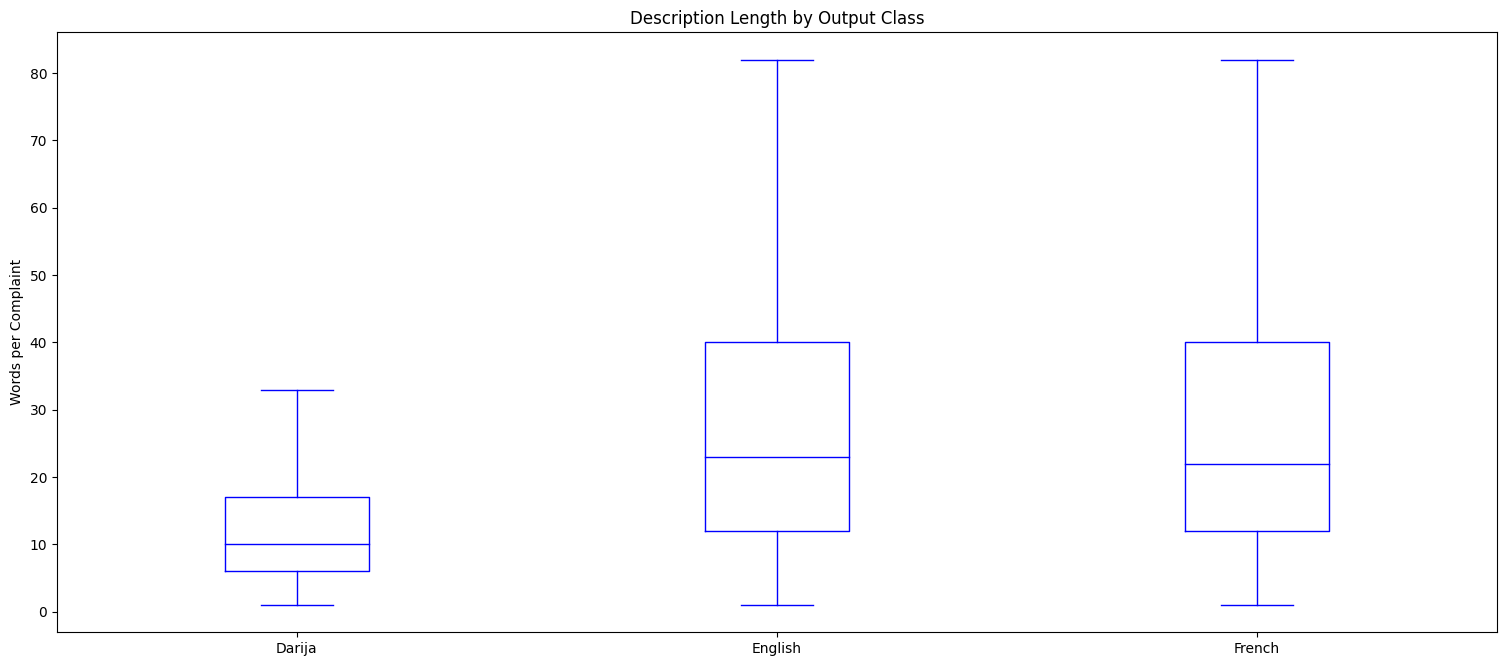

In [6]:
df.boxplot('Text Length', by="labels", grid=False, showfliers=False, color="Blue", figsize=(18, 8))

plt.suptitle('')
plt.title('Description Length by Output Class')
plt.xlabel('')
plt.ylabel('Words per Complaint')
plt.show()

#### Visualize: Number of Samples of Each Language

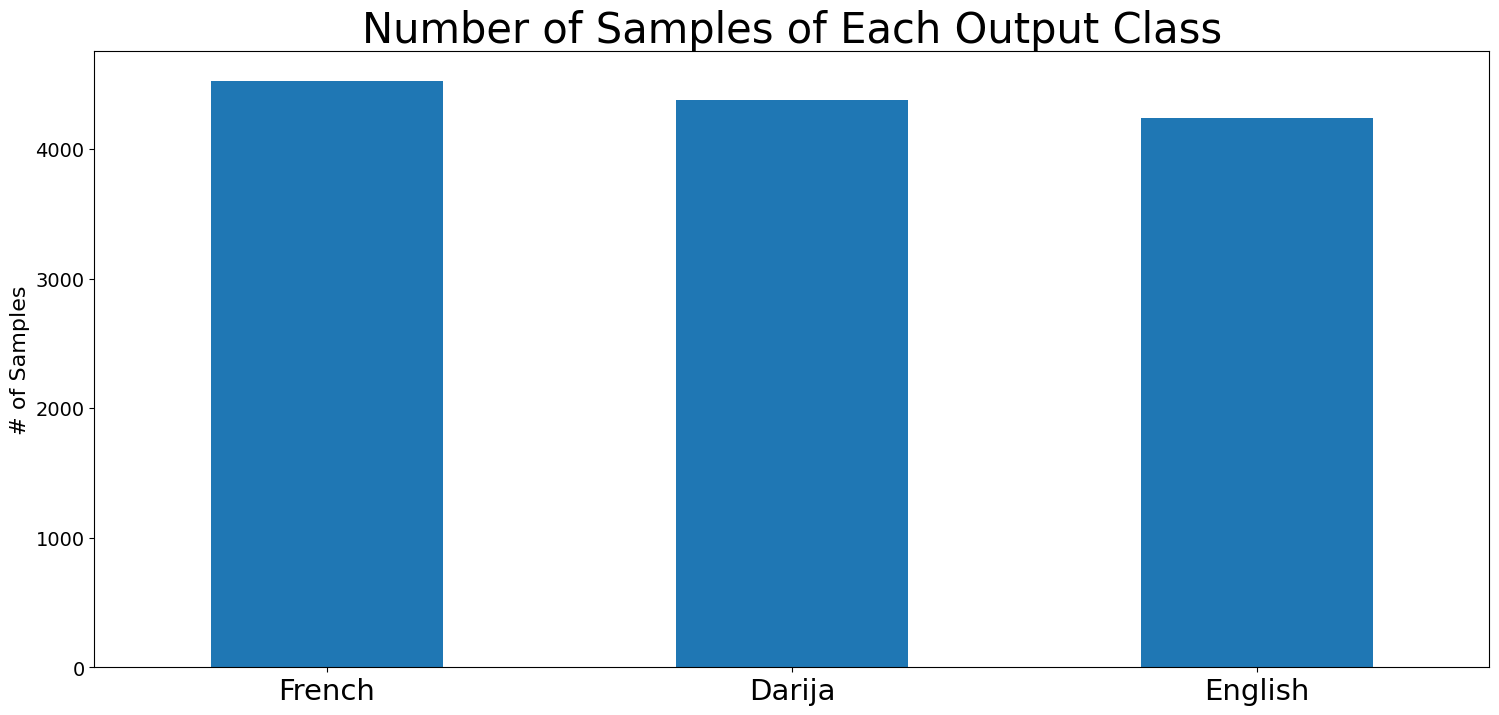

In [7]:
df['labels'].value_counts().plot(kind='bar', figsize=(18, 8))

plt.suptitle('')
plt.title('Number of Samples of Each Output Class', fontsize=30)
plt.xlabel('')
plt.ylabel('# of Samples', fontsize=16)
plt.xticks(rotation='horizontal', fontsize=21)
plt.yticks(rotation='horizontal', fontsize=14)
plt.show()

#### Convert Labels Between String & Integer

In [8]:
LABEL_NAMES = list(set(df['labels']))
NUM_OF_LABELS = len(LABEL_NAMES)

id2label = dict(enumerate(LABEL_NAMES))
label2id = {v: k for k,v in id2label.items()}

print(LABEL_NAMES, '\n', NUM_OF_LABELS)
print("id2label:", id2label)
print("label2id:", label2id)

['English', 'French', 'Darija'] 
 3
id2label: {0: 'English', 1: 'French', 2: 'Darija'}
label2id: {'English': 0, 'French': 1, 'Darija': 2}


#### Final Preprocessing

In [9]:
# Replace String label values with Integer label values
df['labels'].replace(label2id, inplace=True)

# Remove overly lengthy samples
df = df[df["Text Length"] < 91]

# Remove unnecessary Feature
df.drop(columns=["Text Length"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13120 entries, 0 to 13152
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13120 non-null  object
 1   labels  13120 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 307.5+ KB


#### Convert DataFrame to Dataset & Split into Train/Test/Eval Datasets

In [10]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test']
})

print('training data shape:', ds['train'].shape)
print('testing data shape:', ds['test'].shape)
print('validation data shape:', ds['eval'].shape)

training data shape: (10496, 3)
testing data shape: (1312, 3)
validation data shape: (1312, 3)


#### Basic Values/Constants

In [11]:
MODEL_CKPT = "distilbert-base-multilingual-cased"
              
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-language_detection_tweets"

DEVICE = torch.device("cpu")
MAX_INPUT_LENGTH = int(90*1.30)

LEARNING_RATE = 2e-5
set_seed(42)

BATCH_SIZE = 64
NUM_OF_EPOCHS = 3

METRIC_NAME = "f1"
WEIGHT_DECAY = 0.01

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

#### Tokenize Entire Dataset

In [12]:
# Define the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Method to Tokenize each Sample in the Dataset
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=MAX_INPUT_LENGTH)

# Map the 'Tokenize' Method to All Samples in the Entire Dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)
encoded_data = encoded_data

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['eval'].shape)
print(encoded_data['train'][24])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

training data shape: (10496, 5)
testing data shape: (1312, 5)
validation data shape: (1312, 5)
{'text': 'eeerrrii@peeriiwi·3 juin 2021En réponse à @FIANSO192 @S_oufyan  et  @H8MarwaHhhhhhhhhhhhhhhhhh 3ad ylh kan kaygul toto wa3r db aygul toto kdb 3liya wdali rz9i hhhhhhhhh12', 'labels': 2, '__index_level_0__': 10415, 'input_ids': [101, 46179, 10165, 24874, 10116, 137, 56921, 11477, 15926, 217, 124, 13430, 67267, 11259, 10115, 73337, 254, 137, 44168, 69196, 11403, 54055, 10729, 137, 156, 168, 10431, 24203, 10206, 10131, 137, 145, 11396, 11517, 10354, 11037, 12396, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 62992, 10162, 193, 10161, 10237, 10905, 19314, 45837, 47834, 11471, 10884, 10129, 49625, 11538, 45837, 47834, 179, 10162, 10457, 124, 83090, 191, 52662, 186, 10305, 11373, 10116, 176, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 10237, 24747, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Instantiate Model

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, 
                                                           num_labels=NUM_OF_LABELS,
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           ).to(DEVICE)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'classif

#### Define Function to Compute Metrics

In [14]:
def compute_metrics(p):
    ### ------------------- Accuracy -------------------
    
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    logging_first_step=True,
    disable_tqdm=False,
    report_to=REPORTS_TO,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Data Collator

In [16]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Instantiate Trainer

In [17]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["eval"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Cloning https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection_tweets into local empty directory.


#### Train Model

In [18]:
train_results = trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10496
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 492
  Number of trainable parameters = 135326979


A Jupyter Widget

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.1068, 'learning_rate': 1.9959349593495936e-05, 'epoch': 0.01}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1312
  Batch size = 64


{'loss': 0.1713, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-164
Configuration saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-164/config.json


{'eval_loss': 0.016172362491488457, 'eval_accuracy': 0.9954268292682927, 'eval_Weighted F1': 0.9954252874788136, 'eval_Micro F1': 0.9954268292682927, 'eval_Macro F1': 0.9954394081740646, 'eval_Weighted Recall': 0.9954268292682927, 'eval_Micro Recall': 0.9954268292682927, 'eval_Macro Recall': 0.9954854378671721, 'eval_Weighted Precision': 0.9954357683361456, 'eval_Micro Precision': 0.9954268292682927, 'eval_Macro Precision': 0.9954052585025631, 'eval_runtime': 364.9095, 'eval_samples_per_second': 3.595, 'eval_steps_per_second': 0.058, 'epoch': 1.0}


Model weights saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-164/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-164/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-164/special_tokens_map.json
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection_tweets/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection_tweets/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1312
  Batch size = 64


{'loss': 0.0088, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-328
Configuration saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-328/config.json


{'eval_loss': 0.012257151305675507, 'eval_accuracy': 0.9977134146341463, 'eval_Weighted F1': 0.9977134023532217, 'eval_Micro F1': 0.9977134146341463, 'eval_Macro F1': 0.997712592763425, 'eval_Weighted Recall': 0.9977134146341463, 'eval_Micro Recall': 0.9977134146341463, 'eval_Macro Recall': 0.997710819092699, 'eval_Weighted Precision': 0.99772043947398, 'eval_Micro Precision': 0.9977134146341463, 'eval_Macro Precision': 0.9977215111923066, 'eval_runtime': 366.0269, 'eval_samples_per_second': 3.584, 'eval_steps_per_second': 0.057, 'epoch': 2.0}


Model weights saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-328/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-328/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-328/special_tokens_map.json
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection_tweets/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection_tweets/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1312
  Batch size = 64


{'loss': 0.0025, 'learning_rate': 0.0, 'epoch': 3.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-492
Configuration saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-492/config.json


{'eval_loss': 0.005155991297215223, 'eval_accuracy': 0.9992378048780488, 'eval_Weighted F1': 0.9992378028312418, 'eval_Micro F1': 0.9992378048780488, 'eval_Macro F1': 0.9992274968166693, 'eval_Weighted Recall': 0.9992378048780488, 'eval_Micro Recall': 0.9992378048780488, 'eval_Macro Recall': 0.9992266047950503, 'eval_Weighted Precision': 0.9992395651439193, 'eval_Micro Precision': 0.9992378048780488, 'eval_Macro Precision': 0.9992301770592764, 'eval_runtime': 347.452, 'eval_samples_per_second': 3.776, 'eval_steps_per_second': 0.06, 'epoch': 3.0}


Model weights saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-492/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-492/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-492/special_tokens_map.json
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection_tweets/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection_tweets/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-multilingual-cased-language_detection_tweets/checkpoint-492 (score: 0.9992378048780488).


{'train_runtime': 27205.3343, 'train_samples_per_second': 1.157, 'train_steps_per_second': 0.018, 'train_loss': 0.06276771093044824, 'epoch': 3.0}


#### Evaluate Model

In [19]:
output_metrics = trainer.evaluate()

print(output_metrics)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1312
  Batch size = 64


A Jupyter Widget

{'eval_loss': 0.005155991297215223, 'eval_accuracy': 0.9992378048780488, 'eval_Weighted F1': 0.9992378028312418, 'eval_Micro F1': 0.9992378048780488, 'eval_Macro F1': 0.9992274968166693, 'eval_Weighted Recall': 0.9992378048780488, 'eval_Micro Recall': 0.9992378048780488, 'eval_Macro Recall': 0.9992266047950503, 'eval_Weighted Precision': 0.9992395651439193, 'eval_Micro Precision': 0.9992378048780488, 'eval_Macro Precision': 0.9992301770592764, 'eval_runtime': 358.1049, 'eval_samples_per_second': 3.664, 'eval_steps_per_second': 0.059, 'epoch': 3.0}


#### Push Fine-Tuned Model to HuggingFace Hub (My Profile!!!)

In [20]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection_tweets
Configuration saved in distilbert-base-multilingual-cased-language_detection_tweets/config.json
Model weights saved in distilbert-base-multilingual-cased-language_detection_tweets/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection_tweets/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection_tweets/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection_tweets
   9224e96..24eb714  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9992378048780488}]}
To https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection_tweets
   24eb714..2cac5ed  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection_tweets/commit/24eb7142eb8079ef8891dcccc62d3400b3665843'

### Notes & Other Takeaways From This Projects
****
- Wow! Only one wrong answer out of 1312 samples for the evaluation dataset! 
****

### Citations

- Model Checkpoint
    - @article{Sanh2019DistilBERTAD,
  title={DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter},
  author={Victor Sanh and Lysandre Debut and Julien Chaumond and Thomas Wolf},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.01108}
}